과제 : 숫자 데이터 지도 학습 시키기


In [1]:
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

1. 데이터 준비

In [2]:
# 1. Load Data
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')

In [3]:
mnist.data.head(), mnist.target.head()

(   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0       0       0       0       0       0       0       0       0       0   
 1       0       0       0       0       0       0       0       0       0   
 2       0       0       0       0       0       0       0       0       0   
 3       0       0       0       0       0       0       0       0       0   
 4       0       0       0       0       0       0       0       0       0   
 
    pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0        0  ...         0         0         0         0         0         0   
 1        0  ...         0         0         0         0         0         0   
 2        0  ...         0         0         0         0         0         0   
 3        0  ...         0         0         0         0         0         0   
 4        0  ...         0         0         0         0         0         0   
 
    pixel781  pixel782  pixel783  pixel784  
 0 

In [4]:
# 1-3. Split
target = mnist.target.astype(int).to_frame()
feature = mnist.data
print(target.shape, feature.shape)
print(type(target), type(feature))
print(target.nunique())

(70000, 1) (70000, 784)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
class    10
dtype: int64


2. Create DataSet

In [5]:
# 2-1. Define Dataset class
class fashion_dataset(Dataset):
    def __init__(self, x_data, y_data):  # 초기화 함수
        super().__init__()
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data  
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data
        
        # ndarray ==> Tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)

    def __len__(self):  # 갯수 확인 콜백 함수
        return self.target.shape[0]

    def __getitem__(self, index):   # 특정 인덱스 데이터+라벨 반환 콜백 함수
        return self.feature[index], self.target[index]

In [6]:
# 2-2. Set my_dataset
my_dataset = fashion_dataset(feature, target)
# my_dataset[0], feature.iloc[0], target.iloc[0]

In [7]:
# 2-3. Split train, validate, test
from torch.utils.data import random_split

seed = torch.Generator().manual_seed(11)

train_ds, val_ds, test_ds = random_split(my_dataset, [0.7, 0.1, 0.2], generator=seed)
print(f"[train, val, test] {len(train_ds), len(val_ds), len(test_ds)}")

[train, val, test] (49000, 7000, 14000)


3. Create DataLoader

In [8]:
# 3. Create dataLoader
batch = 160
train_dl = DataLoader(train_ds, batch_size=batch)
val_dl = DataLoader(val_ds, batch_size=batch)
test_dl = DataLoader(test_ds, batch_size=batch)
len(train_dl), len(val_dl), len(test_dl)

(307, 44, 88)

4. Define Model Class

In [9]:
# 4. define class
class ClassiModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        in_to_hidden = 100
        hidden_to_out = 50
        super(ClassiModel, self).__init__()
        self.input_layer = nn.Linear(in_dim, in_to_hidden)
        self.relu = nn.ReLU()
        self.hidden_layer = nn.Linear(in_to_hidden, hidden_to_out)
        self.output_layer = nn.Linear(hidden_to_out, out_dim)

    def forward(self, x):
        y = self.input_layer(x)
        y = self.relu(y)
        y = self.hidden_layer(y)
        y = self.relu(y)
        y = self.output_layer(y)
        return y

In [10]:
class NewClassiModel(nn.Module):
    def __init__(self, IN, hidden_sizes, OUT):
        """
        IN: int, 입력 특성의 수
        hidden_sizes: list of int, 각 은닉층의 노드 수
        OUT: int, 출력 노드 수
        model
        """
        super(NewClassiModel, self).__init__()
        self.input_layer = nn.Linear(IN, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], OUT)

    def forward(self, x):
        """
        x: torch.Tensor, 입력 데이터
        """
        y = self.input_layer(x)
        y = self.relu(y)
        for hidden_layer in self.hidden_layers:
            y = hidden_layer(y)
            y = self.relu(y)
        y = self.output_layer(y)
        return y

5. Prepare Training

In [11]:
# 1) Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 2) Train count
Epoch = 20
# 3) Model instance
IN, OUT = my_dataset.feature.shape[1], len(torch.unique(my_dataset.target))
hidden_sizes = [50, 30]
# model = ClassiModel(IN, OUT).to(DEVICE)
model = NewClassiModel(IN, hidden_sizes, OUT).to(DEVICE)

# 4) loss func.
LOSS_FUNC = nn.CrossEntropyLoss().to(DEVICE)

# 5) Optimize instance
import torch.optim as optim

OPTIMIZER = optim.Adam(model.parameters(), lr=0.01)

# 6) Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode="min", patience=10)

# 7) 분류 개수
CLASSES = 10

6. Define Train / Validate functions

In [12]:
import torchmetrics.functional as metrics

In [13]:
target.shape, target.squeeze().shape

((70000, 1), (70000,))

6-1. Train Function

In [14]:
def training(epoch):
    model.train()   # training mode activate
    train_report = [[], [], []]  # [loss, acc]
    for cnt, (feature, target) in enumerate(train_dl):
        feature, target = feature.to(DEVICE), target.to(DEVICE)   # Set to DEVICE
        target = target.squeeze()   # (70000,1) -> (70000,)
        
        pred = model(feature)    # Prediction from feature
        # 손실 계산
        loss = LOSS_FUNC(pred, target)    # Calculate loss function
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pred, target, task="multiclass", num_classes=CLASSES)
        train_report[1].append(acc)
        
        f1 = metrics.f1_score(pred, target, task="multiclass", num_classes=CLASSES)
        train_report[2].append(f1)        
        
        OPTIMIZER.zero_grad()   # Reset W, b
        loss.backward()         # Proceed backward to loss values
        OPTIMIZER.step()        # Update W, b
        
        if not cnt % 50: print('.', end='')
    
    loss_score = (sum(train_report[0]) / batch).item()
    acc_score = (sum(train_report[1]) / len(train_dl)).item()
    f1_score = (sum(train_report[2]) / len(train_dl)).item()
    
    return loss_score, acc_score, f1_score

6-2. Validate Function

In [15]:
def testing(epoch, kind='validation'):
    model.eval()   # testing mode activate
    
    with torch.no_grad():
        test_report = [[], [], []]
        dataLoader = val_dl if kind == 'validation' else test_dl
        for cnt, (feature, target) in enumerate(dataLoader):
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze()
            pred = model(feature)
            
            loss = LOSS_FUNC(pred, target)
            test_report[0].append(loss)
            
            acc = metrics.accuracy(pred, target, task="multiclass", num_classes=CLASSES)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pred, target, task="multiclass", num_classes=CLASSES)
            test_report[2].append(f1)
            
            # OPTIMIZER.zero_grad()   # Reset W, b
            # loss.backward()         # Proceed backward to loss values
            # OPTIMIZER.step()        # Update W, b
            
    testing_type = "Validation" if kind == 'valid' else "Test"
    
    loss_score = (sum(test_report[0])/batch).item()
    acc_score = (sum(test_report[1])/batch).item()
    f1_score = (sum(test_report[2])/batch).item()
    print(f'[{epoch+1} {testing_type}] Loss ==> {loss_score:.3f}, Accuracy ==> {acc_score:.3f}, F1 Score ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

testing(30)

[31 Test] Loss ==> 3.118, Accuracy ==> 0.014, F1 Score ==> 0.014


(3.117560863494873, 0.01372395921498537, 0.01372395921498537)

6. 학습 관련 함수 정의
<hr>

In [16]:
# 학습 중 모델 저장 관련 변수
dir = '../model/'
filename = dir + 'best_model.pth'

import os
if not os.path.exists(dir):
    # os.mkdir(dir)         => 하위 폴더만 생성, data 폴더가 없으면 에러 발생
    os.makedirs(dir)      # => 상위, 하위 폴더 생성

In [17]:
# 학습 및 검증 데이터별 성능 지표 값
train_ = {'loss':[], 'acc':[], 'f1':[]}
val_ = {'loss':[], 'acc':[], 'f1':[]}

# for i, key in enumerate(train_):
#     print(i, key)
pre_va_score = 0    # 모델 저장 관련 함수

for epoch in range(Epoch):
    print(f'[Epoch : {epoch+1}]', end='')
    
    tr_score = training(epoch)
    va_score = testing(epoch, 'validation')
    # print(tr_score, va_score)
    
    for idx, key in enumerate(train_):
        train_[key].append(tr_score[idx])
        val_[key].append(va_score[idx])

print('Training and Validation finished')

[Epoch : 1].......[1 Test] Loss ==> 0.109, Accuracy ==> 0.245, F1 Score ==> 0.245
[Epoch : 2].......[2 Test] Loss ==> 0.101, Accuracy ==> 0.248, F1 Score ==> 0.248
[Epoch : 3].......[3 Test] Loss ==> 0.094, Accuracy ==> 0.249, F1 Score ==> 0.249
[Epoch : 4].......[4 Test] Loss ==> 0.098, Accuracy ==> 0.250, F1 Score ==> 0.250
[Epoch : 5].......[5 Test] Loss ==> 0.101, Accuracy ==> 0.250, F1 Score ==> 0.250
[Epoch : 6].......[6 Test] Loss ==> 0.098, Accuracy ==> 0.250, F1 Score ==> 0.250
[Epoch : 7].......[7 Test] Loss ==> 0.110, Accuracy ==> 0.249, F1 Score ==> 0.249
[Epoch : 8].......[8 Test] Loss ==> 0.116, Accuracy ==> 0.248, F1 Score ==> 0.248
[Epoch : 9].......[9 Test] Loss ==> 0.105, Accuracy ==> 0.250, F1 Score ==> 0.250
[Epoch : 10].......[10 Test] Loss ==> 0.103, Accuracy ==> 0.250, F1 Score ==> 0.250
[Epoch : 11].......[11 Test] Loss ==> 0.126, Accuracy ==> 0.247, F1 Score ==> 0.247
[Epoch : 12].......[12 Test] Loss ==> 0.129, Accuracy ==> 0.245, F1 Score ==> 0.245
[Epoch : 1

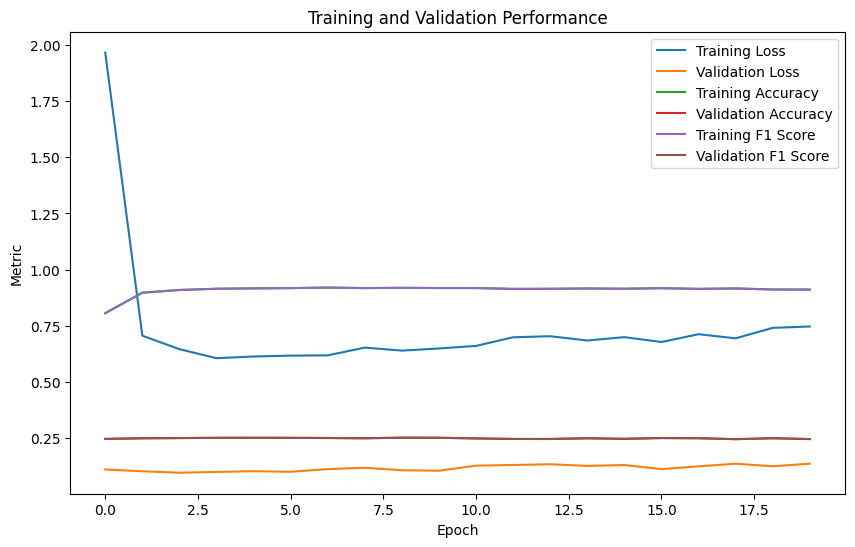

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation performance metrics
plt.figure(figsize=(10, 6))
plt.plot(train_['loss'], label='Training Loss')
plt.plot(val_['loss'], label='Validation Loss')
plt.plot(train_['acc'], label='Training Accuracy')
plt.plot(val_['acc'], label='Validation Accuracy')
plt.plot(train_['f1'], label='Training F1 Score')
plt.plot(val_['f1'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Performance')
plt.legend()
plt.show()


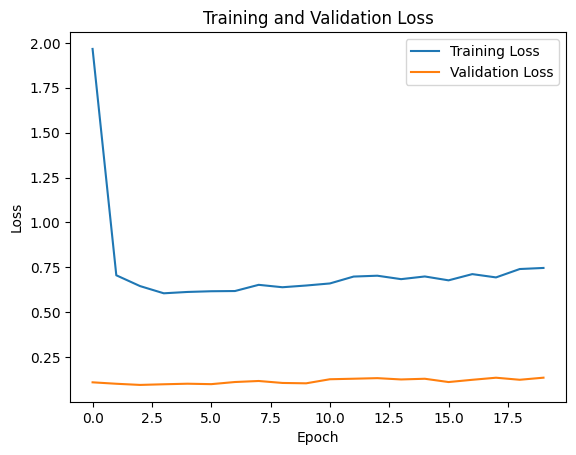

In [19]:
# Plot training and validation loss
plt.plot(train_['loss'], label='Training Loss')
plt.plot(val_['loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Modulelist()

In [20]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(10, 20), nn.ReLU(), nn.Linear(20, 1)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = MyModel()
input_data = torch.randn(10)
output = model(input_data)
print(output)

tensor([0.1763], grad_fn=<ViewBackward0>)
